# Download and interpolate ERA5 climatology from Weatherbench2

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import interp_utils as iu

In [4]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

## Import climatology from WeatherBench 2

In [5]:
# import ERA5 climatology from WeatherBench GS
ds_ERA5_clim = xr.open_zarr(
    'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_1440x721.zarr')

varname_drop = ['boundary_layer_height', 'divergence', '2m_dewpoint_temperature', 'above_ground', 'ageostrophic_wind_speed', 
                'eddy_kinetic_energy', 'geostrophic_wind_speed', 'integrated_vapor_transport', 'lapse_rate', 
                'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'mean_top_downward_short_wave_radiation_flux', 
                'mean_vertically_integrated_moisture_divergence', 'potential_vorticity', 'relative_humidity',
                'snow_depth', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 
                'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'vorticity']

ds_ERA5_clim = ds_ERA5_clim.drop_vars(varname_drop)

## Interpolation

In [6]:
# Define the target 1-degree grid
lon_1deg = np.arange(0, 360, 1)
lat_1deg = np.arange(-90, 91, 1)
target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)

lon_025deg = ds_ERA5_clim['longitude'].values
lat_025deg = ds_ERA5_clim['latitude'].values[::-1]
source_grid = iu.Grid.from_degrees(lon_025deg, lat_025deg)

regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)

In [7]:
ds_ERA5_clim = ds_ERA5_clim.chunk({'longitude': -1, 'latitude': -1})
ds_ERA5_clim = ds_ERA5_clim.isel(latitude=slice(None, None, -1))

ds_clim_1deg = regridder.regrid_dataset(ds_ERA5_clim)

# Reorder the dimensions for all variables in ds_clim_1deg
for var in ds_clim_1deg.data_vars:
    # Get the current dimensions of the variable
    current_dims = ds_clim_1deg[var].dims
    
    # If both 'latitude' and 'longitude' are present, reorder them
    if 'latitude' in current_dims and 'longitude' in current_dims:
        # New order
        new_order = [
            dim for dim in current_dims if dim not in ['latitude', 'longitude']
        ] + ['latitude', 'longitude']
        
        # Transpose the variable to the new order
        ds_clim_1deg[var] = ds_clim_1deg[var].transpose(*new_order)
            
# Add latitude and longitude as coordinates to ds_clim_1deg
ds_clim_1deg = ds_clim_1deg.assign_coords({
    'latitude': lat_1deg,
    'longitude': lon_1deg
})

# flip latitude from -90 --> 90 to 90 --> -90
ds_clim_1deg = ds_clim_1deg.isel(latitude=slice(None, None, -1))

# float64 --> float32
ds_clim_1deg = ds_clim_1deg.astype(
    {var: np.float32 for var in ds_clim_1deg if ds_clim_1deg[var].dtype == np.float64})

# Convert latitude, longitude, and level coordinates to float32
ds_clim_1deg = ds_clim_1deg.assign_coords({
    'latitude': ds_clim_1deg['latitude'].astype(np.float32),
    'longitude': ds_clim_1deg['longitude'].astype(np.float32),
    'level': ds_clim_1deg['level'].astype(np.float32)
})

save_name = conf['ERA5_weatherbench']['save_loc_clim'] + 'ERA5_clim_1990_2019_6h_1deg_interp.nc'
print('Save to {}'.format(save_name))

Save to /glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/ERA5_clim/ERA5_clim_1990_2019_6h_1deg_interp.nc


In [10]:
# ds_clim_1deg.to_netcdf(save_name)

### Plot

In [19]:
# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
ds_clim_1deg['level'].values

array([  50.,  100.,  150.,  200.,  250.,  300.,  400.,  500.,  600.,
        700.,  850.,  925., 1000.], dtype=float32)

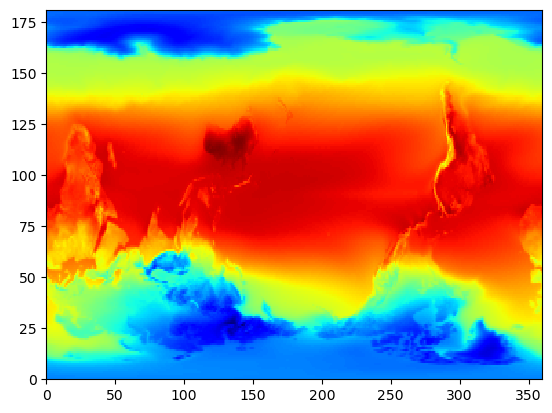

In [24]:
plt.pcolormesh(ds_clim_1deg['2m_temperature'].isel(hour=0, dayofyear=0).values, cmap=plt.cm.jet)

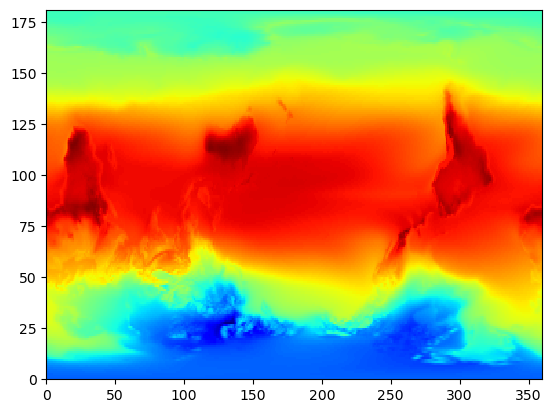

In [26]:
plt.pcolormesh(ds_clim_1deg['temperature'].isel(hour=0, dayofyear=0, level=-1).values, cmap=plt.cm.jet)